In [1]:
#Importing librabries

import pandas as pd
import numpy as np
from numpy import mean, std
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import statistics as st
import scipy.stats as sts
from scipy.spatial import distance
from sklearn.preprocessing import MinMaxScaler, StandardScaler, FunctionTransformer
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import scipy.cluster.hierarchy as sch
import matplotlib.cm as cm
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

# ABSTRACT:

THE MAIN OBJECTIVE OF THE ANALYSIS IS TO APPLY VARIOUS CLUSTERING TECHNIQUES TO CATEGORIZE THE CUSTOMERS VISITING MALL BASED ON THEIR PREVIOUS VISIT, SPENDING SCORE, AGE AND THEIR INCOME IN ORDER TO DEVELOP THE PROFIT 

# DATA EXPLORATION

In [2]:
mall_df = pd.read_csv('DS3_C6_S3_MallCustomers_Data_Project.csv')
mall_df_c = mall_df.drop(columns=['CustomerID'], axis=1)
mall_df_c

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40
...,...,...,...,...
195,Female,35,120,79
196,Female,45,126,28
197,Male,32,126,74
198,Male,32,137,18


# EXPLORATORY DATA ANALYSIS

In [3]:
def bar_percentage(ax,count='number of rows in data'):
    for bar in ax.patches:
        percentage = f"{round((bar.get_height() /count)*100, 2)}%"
        x = bar.get_x() + bar.get_width()/2
        y = bar.get_height()
        ax.annotate(percentage, (x, y), va = "bottom", ha ="center")

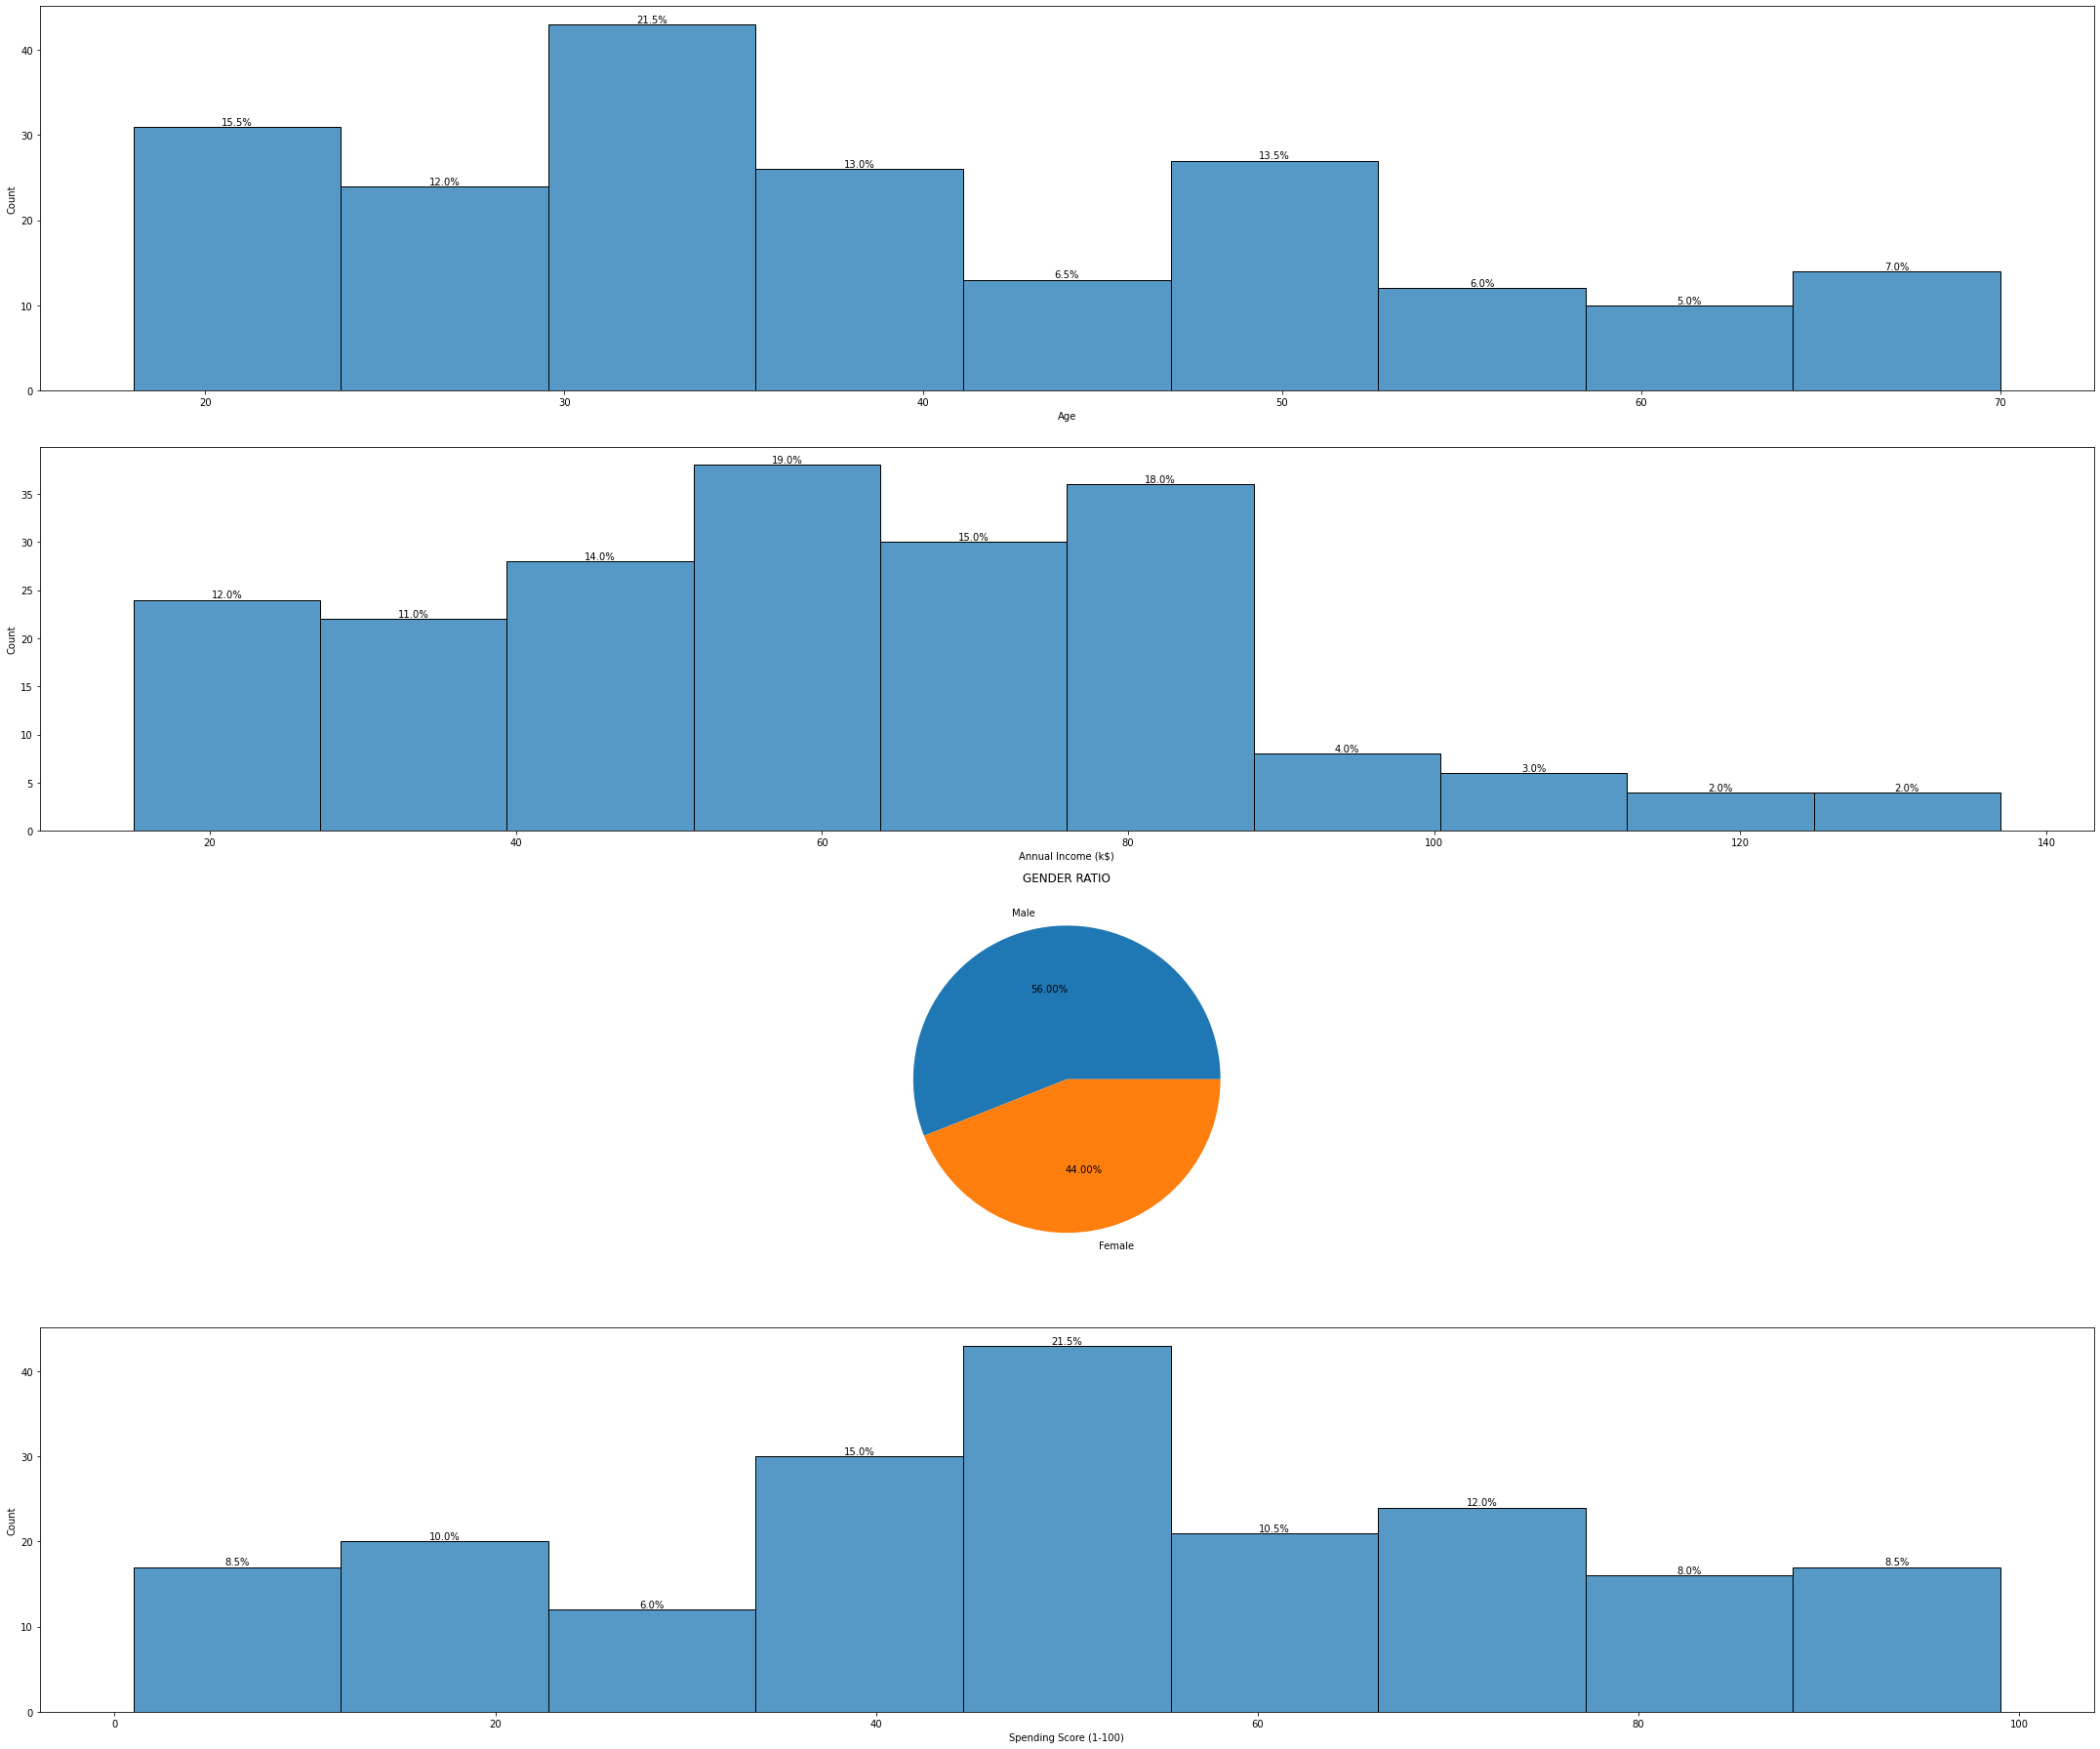

In [4]:
# Plotting the countplot for univariate analysis

fig, ax = plt.subplots(4,1, tight_layout=True ,figsize=(30,25))
bar_percentage(sb.histplot(mall_df['Age'], palette='Set2', ax=ax[0]), len(mall_df))
bar_percentage(sb.histplot(mall_df['Annual Income (k$)'], palette="Set3", ax=ax[1]), len(mall_df))
data = mall_df['Gender'].value_counts()
ax[2].pie(data,autopct='%.2f%%',labels=mall_df['Gender'].unique())
ax[2].set_title('GENDER RATIO')
bar_percentage(sb.histplot(mall_df['Spending Score (1-100)'], palette="Purples", ax=ax[3]), len(mall_df))

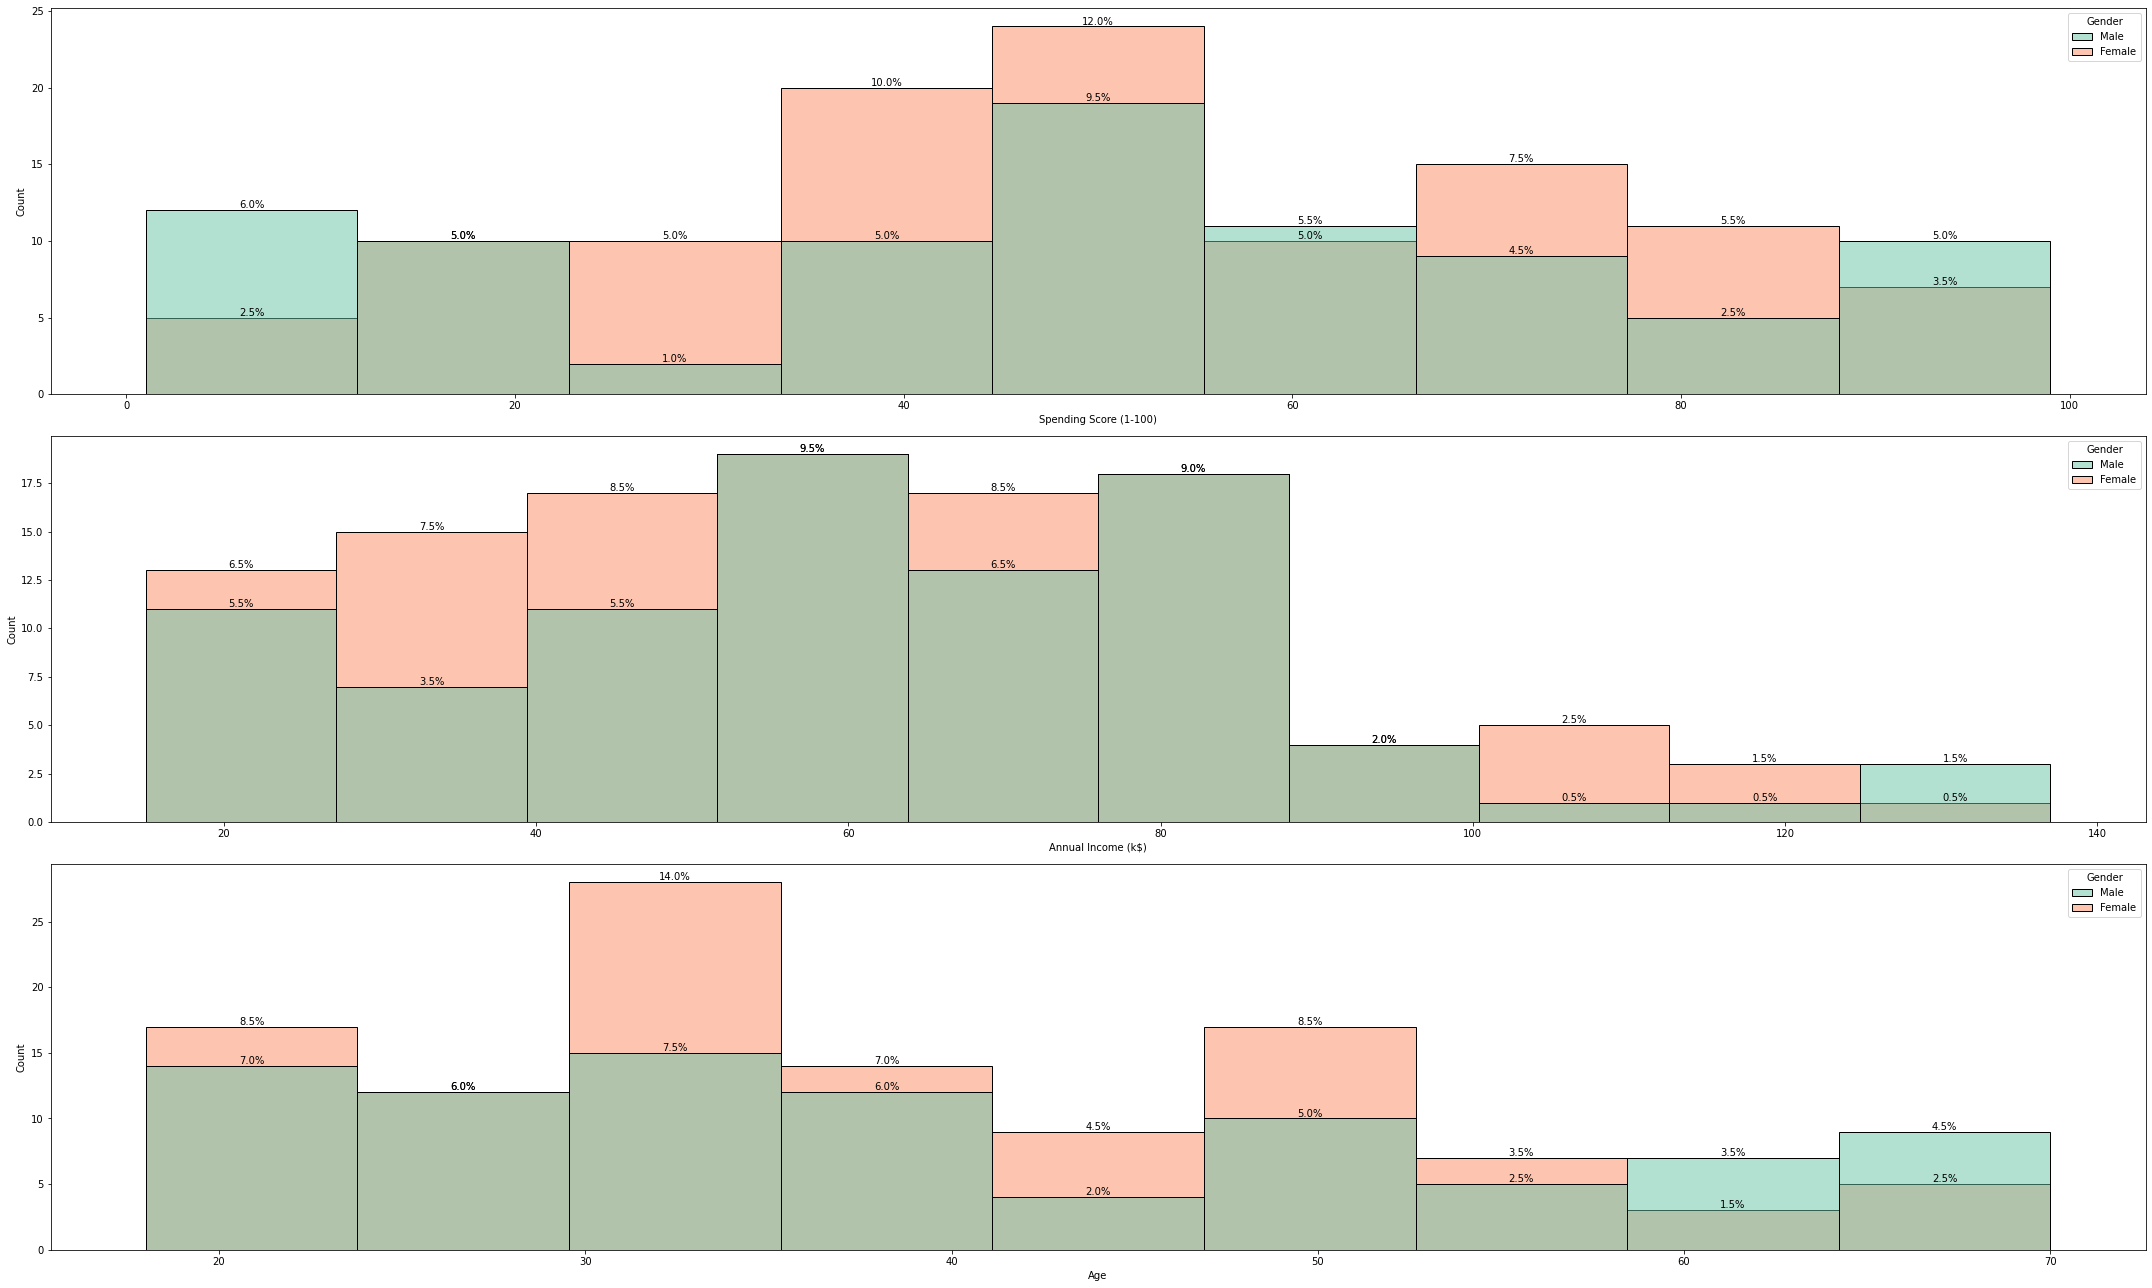

In [5]:
# Plotting the barplot for bivariate analysis

fig, ax = plt.subplots(3,1, tight_layout=True ,figsize=(30,18))
bar_percentage(sb.histplot(hue=mall_df['Gender'], x = mall_df['Spending Score (1-100)'],palette='Set2', ax=ax[0]), len(mall_df))
bar_percentage(sb.histplot(hue=mall_df['Gender'], x = mall_df['Annual Income (k$)'],palette='Set2', ax=ax[1]), len(mall_df))
bar_percentage(sb.histplot(hue=mall_df['Gender'],x = mall_df['Age'], palette="Set2", ax=ax[2]), len(mall_df))

# CONCLUSION:

**1. CUSTOMERS AT THE AGE OF 30 TO 40 YEARS ARE HIGH IN NUMBERS AND MAJORITY ARE EARNING BETWEEN 40 TO 90 K$.**

**2. CUSTOMERS ARE MOSTLY MALE WITH 56 % MAJORITY.**

**3. MAXIMUM SPENDING SCORE LIES BETWEEN 40 TO 50.**

**4. MALE SPENDING SCORE IS BETTER THAN FEMALE THOUGH INCOME IS HIGHER FOR MALE AND LESS FOR FEMALE WHICH EVIDENTS FEMALE CUSTOMERS LEAD TO HIGH SALES RATE.**

**5. MAJORITY OF BOTH MALE AND FEMALE CUSTOMERS BELONGS TO THE AGE GROUP OF 30 TO 40.**

# DATA PREPROCESSING

In [6]:
def DataPreprocessing(Df, scaler, purpose, TargetFeature=None):
    import pandas as pd
    import numpy as np
    from numpy import mean, std
    from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, FunctionTransformer
    numerics = ['int64', 'int32', 'float64', 'float32', 'int16', 'float16']
    print(f"Shape of the Df : {Df.shape}\n")
    print(f"Summary of the Df : \n\n{Df.describe()}\n")
    print(f"\nInformation about the Df : \n{Df.info()}\n")
    print(f"\nNull values is the Df : \n\n{Df.isnull().sum()}\n")
    for i in Df:
        if Df[i].dtype in numerics:
            if Df[i].isnull().sum() > 0 or Df[i].isnull().sum() < int(len(Df[i])*0.70):
                Df[i].fillna(Df[i].mean(), inplace = True)
            else:
                Df.drop(columns=[i],axis=1,inplace=True)
                Df.reset_index(drop=True)
        else:
            if Df[i].isnull().sum() > 0 or Df[i].isnull().sum() < int(len(Df[i])*0.70):
                Df[i].fillna(Df[i].mode()[0], inplace = True)
            else:
                Df.drop(columns=[i],axis=1,inplace=True).reset_index(drop=True)
                Df.reset_index(drop=True)
        print(f"Checking null in the feature {i}...! Null = {Df[i].isnull().sum()}\n")
    if purpose != 'Clustering':
        for i in Df:
            if Df[i].dtype == 'object':
                Df[i] = Df[i].astype('category')
                Df[i+'_encoded'] = LabelEncoder().fit_transform(Df[i])
    elif purpose == 'Clustering':
        print('\nSince clustering is chosen Categorical columns are not considered \n\n')
    scale = lambda scaler: MinMaxScaler() if scaler=='Normalize' else StandardScaler()    
    df_after_scaling = pd.DataFrame(scale(scaler).fit_transform(Df[list(Df.select_dtypes(include=numerics))].to_numpy()), columns = Df[list(Df.select_dtypes(include=numerics))].columns)
    print(df_after_scaling,'\n\n')
    corr = df_after_scaling.corr()
    if purpose == 'Classification':
        df_after_scaling.drop(columns=[TargetFeature+'_encoded'], axis=1, inplace=True)
        df_after_scaling = pd.concat([df_after_scaling, Df[TargetFeature+'_encoded']], axis=1)
    if purpose != 'Clustering':
        corr = df_after_scaling.corr()
        cor = float(input('Enter the Correlation to be considered : '))
        l1 = []
        for i in df_after_scaling:
            if abs(df_after_scaling[i].corr(df_after_scaling[TargetFeature+'_encoded'])) >= cor:
                l1.append(i)
        new_scaled_df = df_after_scaling[l1]
        print(new_scaled_df)
    elif purpose == 'Clustering' and TargetFeature != None:
        l1 = []
        for i in df_after_scaling:
            if abs(df_after_scaling[i].corr(df_after_scaling[TargetFeature+'_encoded'])) >= cor:
                l1.append(i)
        new_scaled_df = df_after_scaling[l1]
        print(new_scaled_df)
    elif purpose == 'Clustering':
        new_scaled_df = df_after_scaling
    return(new_scaled_df)

In [7]:
mall_data = DataPreprocessing(mall_df_c, 'Standard', purpose='Clustering')
mall_data

Shape of the Df : (200, 4)

Summary of the Df : 

              Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000          200.000000              200.000000
mean    38.850000           60.560000               50.200000
std     13.969007           26.264721               25.823522
min     18.000000           15.000000                1.000000
25%     28.750000           41.500000               34.750000
50%     36.000000           61.500000               50.000000
75%     49.000000           78.000000               73.000000
max     70.000000          137.000000               99.000000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Gender                  200 non-null    object
 1   Age                     200 non-null    int64 
 2   Annual Income (k$)      200 non-null    int64 
 3   Spending Score (1-100)

,Age,Annual Income (k$),Spending Score (1-100)
0,-1.424569,-1.738999,-0.434801
1,-1.281035,-1.738999,1.195704
2,-1.352802,-1.700830,-1.715913
3,-1.137502,-1.700830,1.040418
4,-0.563369,-1.662660,-0.395980
...,...,...,...
195,-0.276302,2.268791,1.118061
196,0.441365,2.497807,-0.861839
197,-0.491602,2.497807,0.923953
198,-0.491602,2.917671,-1.250054


# MODEL BUILDING AND EVALUATION

In [8]:
def pca_or_lda( attributes,  scaled_values, x=None, y=None, dimension_reduction='pca', components=2):
    components = min(components, len(attributes))
    print(components,'\n\n')
    if dimension_reduction == 'pca':
        values = PCA().fit_transform(scaled_values)[:, :components]
        print(values.shape)
    elif dimension_reduction == 'lda':
        values = LinearDiscriminantAnalysis(n_components=2).fit_transform(x.values,y.values)[:, :components]
        print(values.shape)  
    else:
        values = scaled_values
    return (pd.DataFrame(values))

In [9]:
pca = pca_or_lda(mall_data.columns, mall_data)
pca

2 


(200, 2)


,0,1
0,-0.615720,-1.763481
1,-1.665793,-1.820747
2,0.337862,-1.674799
3,-1.456573,-1.772430
4,-0.038465,-1.662740
...,...,...
195,-1.093705,2.215577
196,0.800448,2.540748
197,-1.119709,2.445169
198,0.395411,2.946665


In [10]:
type(pca)

pandas.core.frame.DataFrame

In [11]:
def algorithms(algorithm, Df, show, Df_without_labels=None, affinity='euclidean', linkage='ward', k = 4):
    
    if algorithm == 'kmeans':
        range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
        distorsions = []
        for k in range_n_clusters:
            kmeans = KMeans(n_clusters=k)
            kmeans.fit(Df)
            distorsions.append(kmeans.inertia_)

        fig = plt.figure(figsize=(15, 5))
        plt.plot(range(2, 11), distorsions)
        plt.grid(True)
        plt.xlabel('K')
        plt.ylabel('Distorsions')
        plt.title('Elbow curve')
        plt.show()
        for n_clusters in range_n_clusters:
            clusterer = KMeans(n_clusters=n_clusters, random_state=10)
            cluster_labels = clusterer.fit_predict(Df)
            silhouette_avg = silhouette_score(Df, cluster_labels)
            print("For n_clusters =", n_clusters,
                  "The average silhouette_score is :", silhouette_avg)
            
        k = int(input('Enter the K or n_clusters value : '))
        
        cluster = KMeans(n_clusters=k).fit_predict(Df)
        if show == 'features':
            df_plot = Df_without_labels.astype(float).copy()
        elif show == 'values':
            df_plot = pd.DataFrame(Df)
        df_plot['cluster'] = cluster
        
    if algorithm == 'hierarchial':
        if type(Df) != 'numpy.ndarray':
            plt.figure(figsize=(30, 10))
            dendrogrm = sch.dendrogram(sch.linkage(Df, method = 'ward'),labels=Df.index)
            ax = plt.gca()
            ax.tick_params(axis='x', which='major', labelsize=10)
            plt.title('Dendrogram',fontsize=30)
            plt.show()

            k = int(input('Enter the K or n_clusters value : '))
        
        hc = AgglomerativeClustering(n_clusters = k, affinity = 'euclidean', linkage = 'ward')
        y_hc = hc.fit_predict(Df.values)
        cluster1 = AgglomerativeClustering(n_clusters = k, affinity = 'euclidean', linkage = 'ward').fit_predict(Df)
        if show == 'features':
            df_plot = Df_without_labels.astype(float).copy()
        elif show == 'values':
            df_plot = pd.DataFrame(Df)
        df_plot['cluster'] = cluster1
        
    if algorithm == 'dbscan':
        from sklearn.neighbors import NearestNeighbors
        
        neigh = NearestNeighbors(n_neighbors=2)
        nbrs = neigh.fit(Df)
        distances, indices = nbrs.kneighbors(Df)
        # Plotting K-distance Graph
        distances = np.sort(distances, axis=0)
        distances = distances[:,1]
        plt.figure(figsize=(15,8))
        plt.plot(distances)
        plt.title('K-distance Graph',fontsize=20)
        plt.xlabel('Data Points sorted by distance',fontsize=14)
        plt.ylabel('Epsilon',fontsize=14)
        plt.show()
        
        eps = float(input('Enter the eps or Epsilon value : '))
        
        neigh = NearestNeighbors(n_neighbors=2)
        nbrs = neigh.fit(Df)
        distances, indices = nbrs.kneighbors(Df)
        
        distances = np.sort(distances, axis=0)
        distances = distances[:,1]
        plt.figure(figsize=(15,8))
        plt.plot(distances)
        plt.axhline(y=eps, color='r', linestyle='--')
        plt.title('K-distance Graph',fontsize=20)
        plt.xlabel('Data Points sorted by distance',fontsize=14)
        plt.ylabel('Epsilon',fontsize=14)
        plt.show()
        
        eps=eps
        for min_samples in range(1,16):
            clusterer = DBSCAN(eps=eps, min_samples=min_samples)
            cluster_labels = clusterer.fit_predict(Df)

            x= cluster_labels +2
            y = np.bincount(x)
            ii = np.nonzero(y)[0]
            results = list(zip(ii,y[ii]) )
            print('eps=',eps,'| min_samples= ', min_samples, '| obtained clustering: ', results)
            
        min_samples = int(input('Enter the min_samples to be considered : '))
        
        dbscan_opt=DBSCAN(eps=eps,min_samples=min_samples)
        dbscan_opt.fit(Df)
        cluster2 = DBSCAN(eps=eps,min_samples=min_samples).fit_predict(Df)
        if show == 'features':
            df_plot = Df_without_labels.astype(float).copy()
        elif show == 'values':
            df_plot = pd.DataFrame(Df)
        df_plot['cluster'] = cluster2
    return (df_plot)

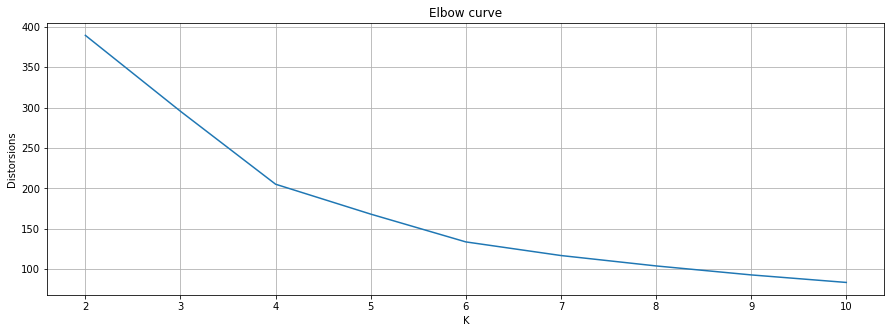

For n_clusters = 2 The average silhouette_score is : 0.33547192894004574
For n_clusters = 3 The average silhouette_score is : 0.35880977401117803
For n_clusters = 4 The average silhouette_score is : 0.4039582785148566
For n_clusters = 5 The average silhouette_score is : 0.41664341513732767
For n_clusters = 6 The average silhouette_score is : 0.42742814991580175
For n_clusters = 7 The average silhouette_score is : 0.417231894954916
For n_clusters = 8 The average silhouette_score is : 0.408443059554235
For n_clusters = 9 The average silhouette_score is : 0.4188078334648395
For n_clusters = 10 The average silhouette_score is : 0.4003965743727067
Enter the K or n_clusters value : 6


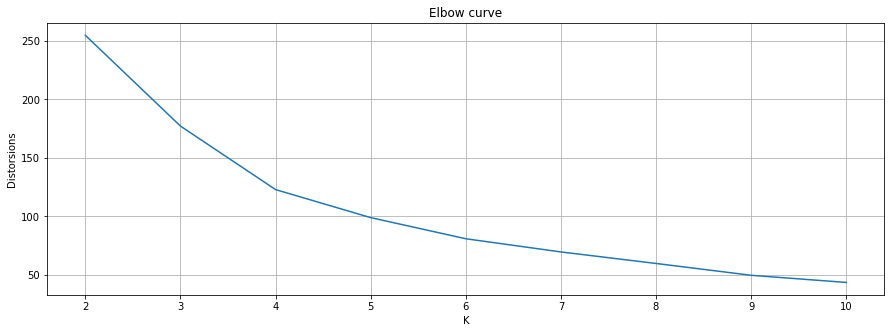

For n_clusters = 2 The average silhouette_score is : 0.4256333145815097
For n_clusters = 3 The average silhouette_score is : 0.41362382732916375
For n_clusters = 4 The average silhouette_score is : 0.42092860310837965
For n_clusters = 5 The average silhouette_score is : 0.3898114280785038
For n_clusters = 6 The average silhouette_score is : 0.38216953159460026
For n_clusters = 7 The average silhouette_score is : 0.3755697672869317
For n_clusters = 8 The average silhouette_score is : 0.39764625847952684
For n_clusters = 9 The average silhouette_score is : 0.39544393871608613
For n_clusters = 10 The average silhouette_score is : 0.38530053633418926
Enter the K or n_clusters value : 4


In [12]:
mall_k_means = algorithms('kmeans', mall_data, 'values')
mall_k_means_pca = algorithms('kmeans', pca, 'values')

In [19]:
mall_k_means

,Age,Annual Income (k$),Spending Score (1-100),cluster
0,-1.424569,-1.738999,-0.434801,-1
1,-1.281035,-1.738999,1.195704,0
2,-1.352802,-1.700830,-1.715913,-1
3,-1.137502,-1.700830,1.040418,0
4,-0.563369,-1.662660,-0.395980,-1
...,...,...,...,...
195,-0.276302,2.268791,1.118061,-1
196,0.441365,2.497807,-0.861839,-1
197,-0.491602,2.497807,0.923953,-1
198,-0.491602,2.917671,-1.250054,-1


In [20]:
mall_k_means_pca

,0,1,cluster
0,-0.615720,-1.763481,-1
1,-1.665793,-1.820747,0
2,0.337862,-1.674799,-1
3,-1.456573,-1.772430,0
4,-0.038465,-1.662740,-1
...,...,...,...
195,-1.093705,2.215577,-1
196,0.800448,2.540748,-1
197,-1.119709,2.445169,-1
198,0.395411,2.946665,-1


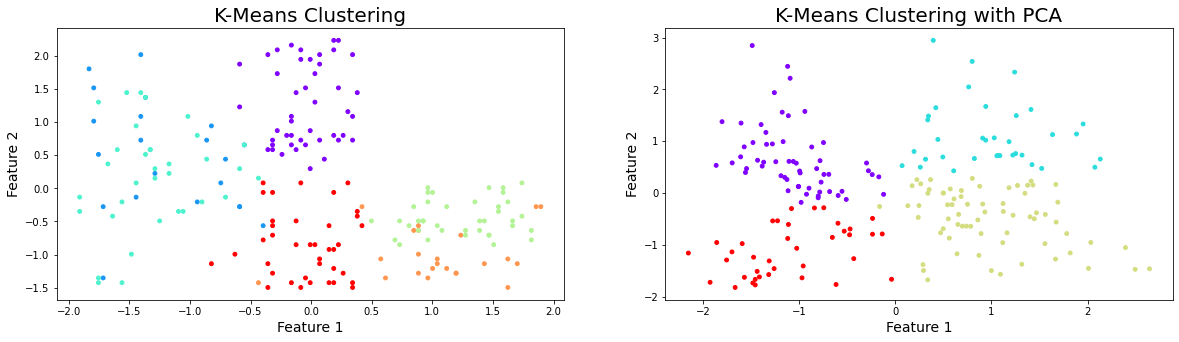

In [27]:
figure, ax = plt.subplots(1,2,figsize=(20,5))
ax[0].scatter(mall_k_means['Spending Score (1-100)'],mall_k_means['Age'],c=mall_k_means['cluster'],cmap='rainbow',s=15)
ax[0].set_title('K-Means Clustering',fontsize=20)
ax[0].set_xlabel('Feature 1',fontsize=14)
ax[0].set_ylabel('Feature 2',fontsize=14)
ax[1].scatter(mall_k_means_pca[0],mall_k_means_pca[1],c=mall_k_means_pca['cluster'],cmap='rainbow',s=15)
ax[1].set_title('K-Means Clustering with PCA',fontsize=20)
ax[1].set_xlabel('Feature 1',fontsize=14)
ax[1].set_ylabel('Feature 2',fontsize=14)
plt.show()

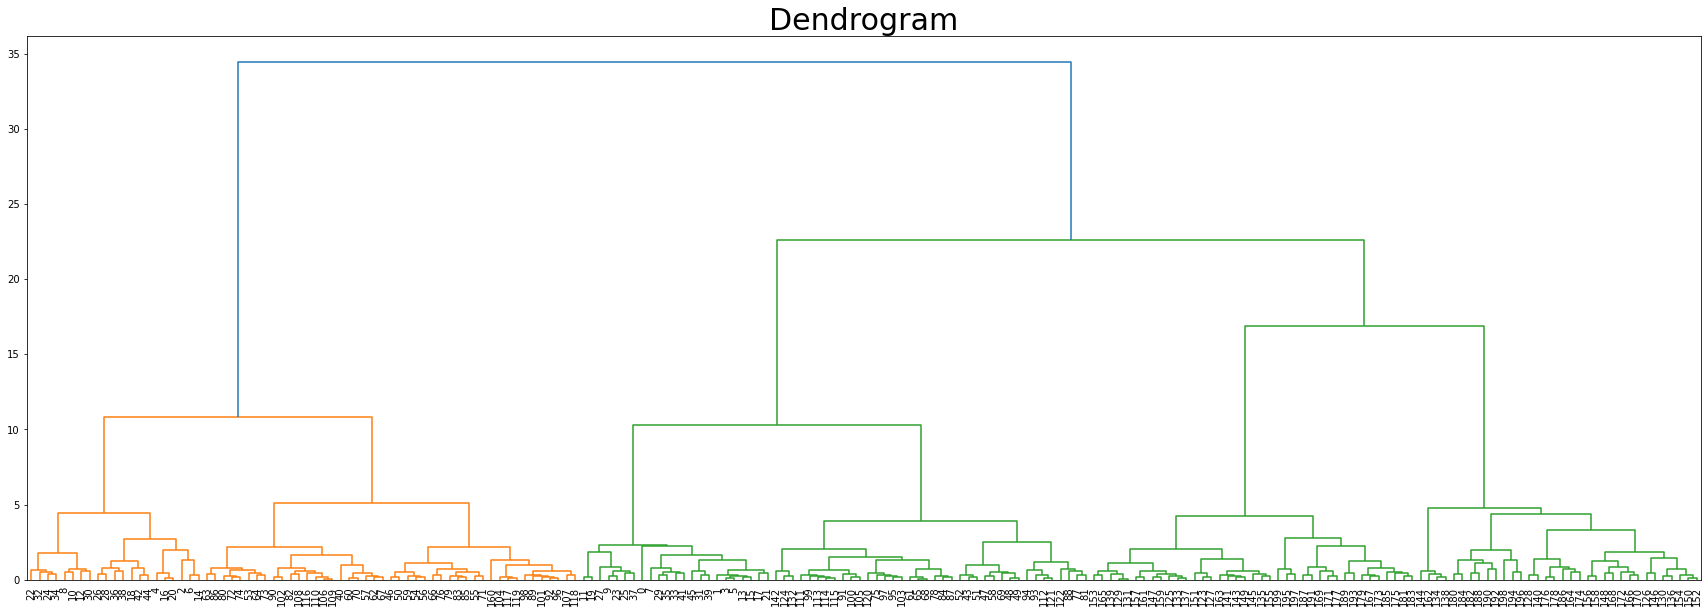

Enter the K or n_clusters value : 4


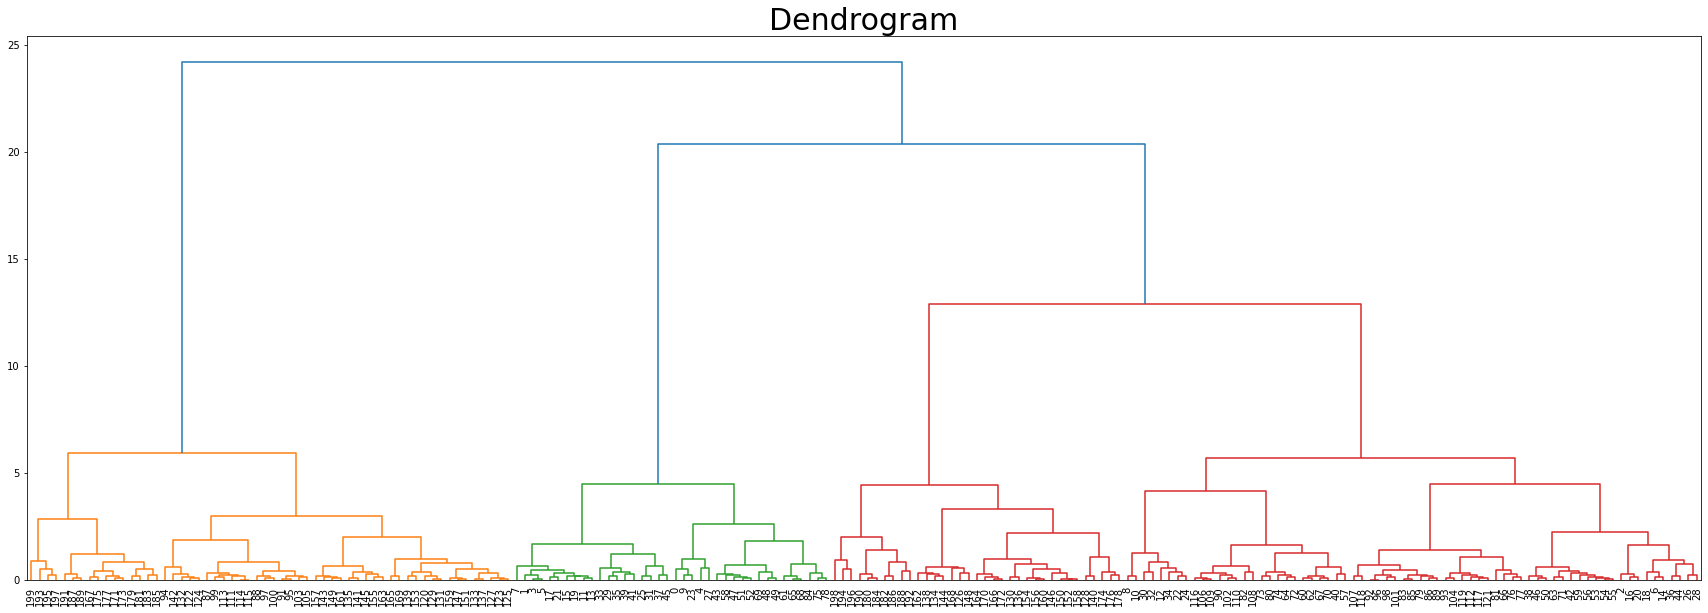

Enter the K or n_clusters value : 4


In [14]:
mall_hierarchial = algorithms('hierarchial', mall_data, 'values')
mall_hierarchial_pca = algorithms('hierarchial', pca, 'values')

In [21]:
mall_hierarchial

,Age,Annual Income (k$),Spending Score (1-100),cluster
0,-1.424569,-1.738999,-0.434801,-1
1,-1.281035,-1.738999,1.195704,0
2,-1.352802,-1.700830,-1.715913,-1
3,-1.137502,-1.700830,1.040418,0
4,-0.563369,-1.662660,-0.395980,-1
...,...,...,...,...
195,-0.276302,2.268791,1.118061,-1
196,0.441365,2.497807,-0.861839,-1
197,-0.491602,2.497807,0.923953,-1
198,-0.491602,2.917671,-1.250054,-1


In [22]:
mall_hierarchial_pca

,0,1,cluster
0,-0.615720,-1.763481,-1
1,-1.665793,-1.820747,0
2,0.337862,-1.674799,-1
3,-1.456573,-1.772430,0
4,-0.038465,-1.662740,-1
...,...,...,...
195,-1.093705,2.215577,-1
196,0.800448,2.540748,-1
197,-1.119709,2.445169,-1
198,0.395411,2.946665,-1


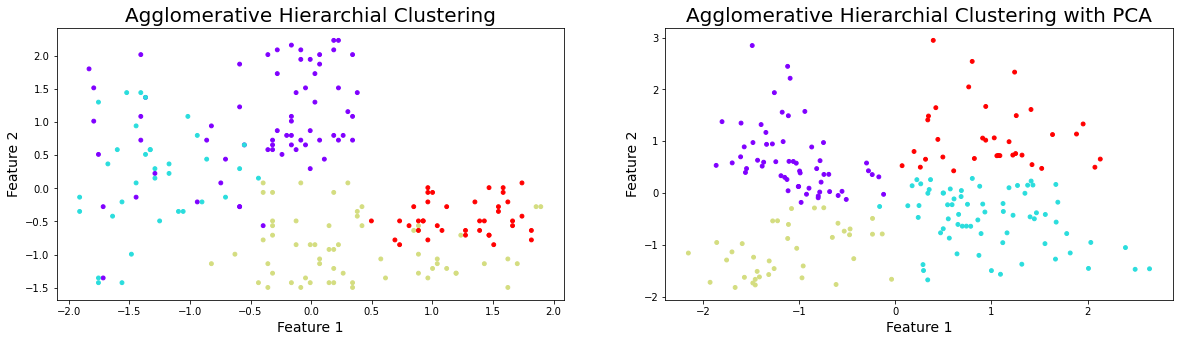

In [28]:
figure, ax = plt.subplots(1,2,figsize=(20,5))
ax[0].scatter(mall_hierarchial['Spending Score (1-100)'],mall_hierarchial['Age'],c=mall_hierarchial['cluster'],cmap='rainbow',s=15)
ax[0].set_title('Agglomerative Hierarchial Clustering',fontsize=20)
ax[0].set_xlabel('Feature 1',fontsize=14)
ax[0].set_ylabel('Feature 2',fontsize=14)
ax[1].scatter(mall_hierarchial_pca[0],mall_hierarchial_pca[1],c=mall_hierarchial_pca['cluster'],cmap='rainbow',s=15)
ax[1].set_title('Agglomerative Hierarchial Clustering with PCA',fontsize=20)
ax[1].set_xlabel('Feature 1',fontsize=14)
ax[1].set_ylabel('Feature 2',fontsize=14)
plt.show()

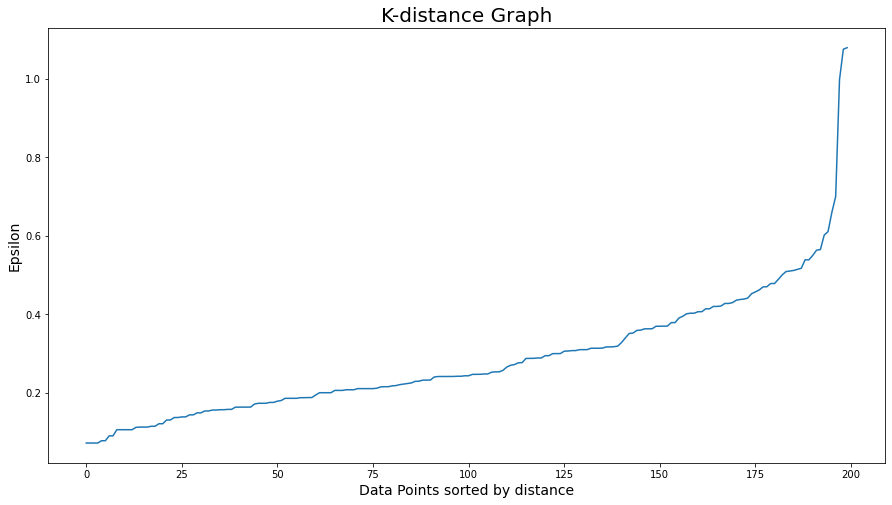

Enter the eps or Epsilon value : 0.6


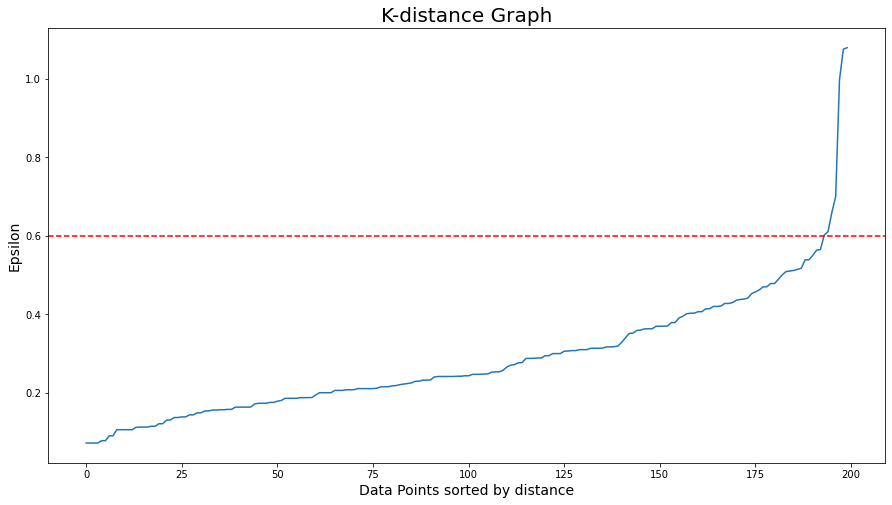

eps= 0.6 | min_samples=  1 | obtained clustering:  [(2, 1), (3, 57), (4, 1), (5, 62), (6, 2), (7, 2), (8, 1), (9, 39), (10, 23), (11, 2), (12, 4), (13, 1), (14, 1), (15, 1), (16, 2), (17, 1)]
eps= 0.6 | min_samples=  2 | obtained clustering:  [(1, 7), (2, 57), (3, 62), (4, 2), (5, 2), (6, 39), (7, 23), (8, 2), (9, 4), (10, 2)]
eps= 0.6 | min_samples=  3 | obtained clustering:  [(1, 15), (2, 57), (3, 62), (4, 39), (5, 23), (6, 4)]
eps= 0.6 | min_samples=  4 | obtained clustering:  [(1, 20), (2, 57), (3, 61), (4, 36), (5, 22), (6, 4)]
eps= 0.6 | min_samples=  5 | obtained clustering:  [(1, 31), (2, 56), (3, 60), (4, 35), (5, 18)]
eps= 0.6 | min_samples=  6 | obtained clustering:  [(1, 39), (2, 54), (3, 6), (4, 5), (5, 45), (6, 34), (7, 17)]
eps= 0.6 | min_samples=  7 | obtained clustering:  [(1, 56), (2, 51), (3, 47), (4, 34), (5, 12)]
eps= 0.6 | min_samples=  8 | obtained clustering:  [(1, 58), (2, 50), (3, 46), (4, 34), (5, 12)]
eps= 0.6 | min_samples=  9 | obtained clustering:  [(1, 7

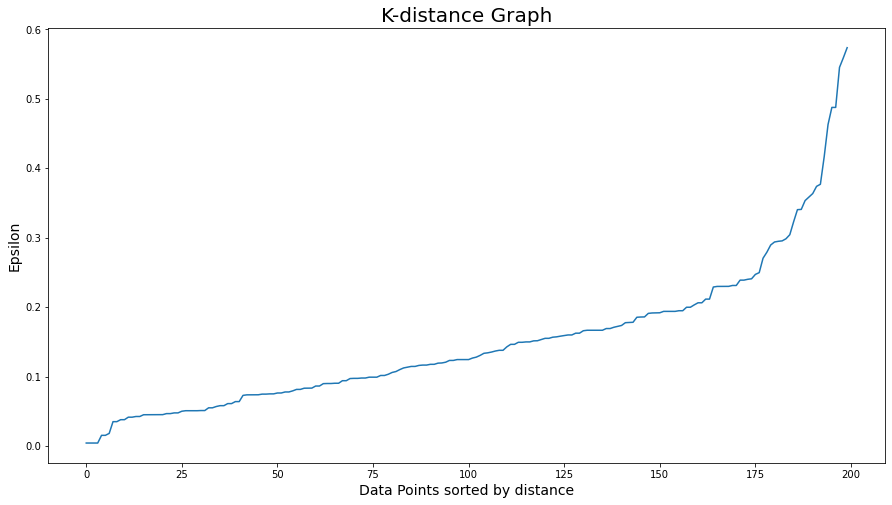

Enter the eps or Epsilon value : 0.3


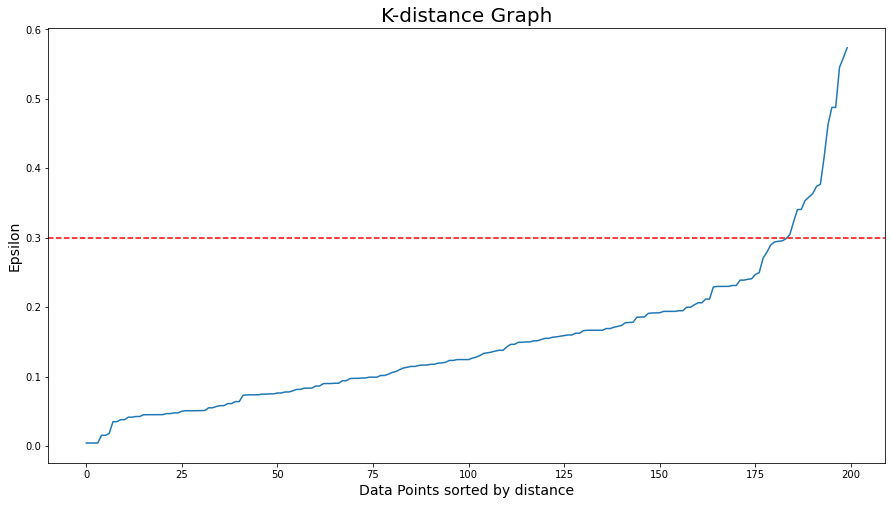

eps= 0.3 | min_samples=  1 | obtained clustering:  [(2, 1), (3, 16), (4, 3), (5, 1), (6, 3), (7, 2), (8, 2), (9, 1), (10, 3), (11, 2), (12, 1), (13, 1), (14, 1), (15, 47), (16, 8), (17, 7), (18, 1), (19, 46), (20, 7), (21, 1), (22, 4), (23, 6), (24, 2), (25, 13), (26, 1), (27, 3), (28, 3), (29, 2), (30, 3), (31, 1), (32, 1), (33, 1), (34, 1), (35, 2), (36, 1), (37, 1), (38, 1)]
eps= 0.3 | min_samples=  2 | obtained clustering:  [(1, 16), (2, 16), (3, 3), (4, 3), (5, 2), (6, 2), (7, 3), (8, 2), (9, 47), (10, 8), (11, 7), (12, 46), (13, 7), (14, 4), (15, 6), (16, 2), (17, 13), (18, 3), (19, 3), (20, 2), (21, 3), (22, 2)]
eps= 0.3 | min_samples=  3 | obtained clustering:  [(1, 28), (2, 16), (3, 3), (4, 3), (5, 3), (6, 47), (7, 7), (8, 8), (9, 46), (10, 7), (11, 4), (12, 6), (13, 13), (14, 3), (15, 3), (16, 3)]
eps= 0.3 | min_samples=  4 | obtained clustering:  [(1, 54), (2, 16), (3, 46), (4, 7), (5, 5), (6, 43), (7, 7), (8, 4), (9, 13), (10, 5)]
eps= 0.3 | min_samples=  5 | obtained clust

In [16]:
mall_db = algorithms('dbscan', mall_data, 'values')
mall_db_pca = algorithms('dbscan', pca, 'values')

In [23]:
mall_db

,Age,Annual Income (k$),Spending Score (1-100),cluster
0,-1.424569,-1.738999,-0.434801,-1
1,-1.281035,-1.738999,1.195704,0
2,-1.352802,-1.700830,-1.715913,-1
3,-1.137502,-1.700830,1.040418,0
4,-0.563369,-1.662660,-0.395980,-1
...,...,...,...,...
195,-0.276302,2.268791,1.118061,-1
196,0.441365,2.497807,-0.861839,-1
197,-0.491602,2.497807,0.923953,-1
198,-0.491602,2.917671,-1.250054,-1


In [24]:
mall_db_pca

,0,1,cluster
0,-0.615720,-1.763481,-1
1,-1.665793,-1.820747,0
2,0.337862,-1.674799,-1
3,-1.456573,-1.772430,0
4,-0.038465,-1.662740,-1
...,...,...,...
195,-1.093705,2.215577,-1
196,0.800448,2.540748,-1
197,-1.119709,2.445169,-1
198,0.395411,2.946665,-1


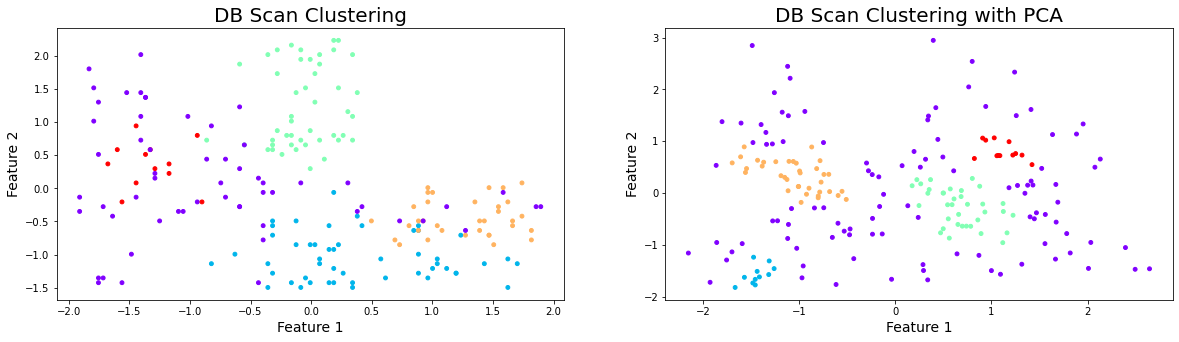

In [29]:
figure, ax = plt.subplots(1,2,figsize=(20,5))
ax[0].scatter(mall_db['Spending Score (1-100)'],mall_db['Age'],c=mall_db['cluster'],cmap='rainbow',s=15)
ax[0].set_title('DB Scan Clustering',fontsize=20)
ax[0].set_xlabel('Feature 1',fontsize=14)
ax[0].set_ylabel('Feature 2',fontsize=14)
ax[1].scatter(mall_db_pca[0],mall_db_pca[1],c=mall_db_pca['cluster'],cmap='rainbow',s=15)
ax[1].set_title('DB Scan Clustering with PCA',fontsize=20)
ax[1].set_xlabel('Feature 1',fontsize=14)
ax[1].set_ylabel('Feature 2',fontsize=14)
plt.show()

# CONCLUSION:

**1. Using on the different clustering algorithm we have managed to form different clusters based on different features.** 

**2. Mall management can target the clusters with average spending score to increase their profit and should also maintain good relationship with premium customers with high spending score.**

**3. They should also work on coming up with new innovative ideas to upgrade the customers with low spending score.**

**4. With the dimensionality reduction technique PCA the clustering is more accurate and precise.**